In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import random
import re
import nltk
import time
import plotly.express as px
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest , f_classif
from tqdm import tqdm as t
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from nltk.corpus import stopwords


# 1. Load the dataset

* The following code snippet is from the tutorial Google's Machine Learning Course. <https://developers.google.com/machine-learning/guides/text-classification/step-2>

In [2]:
def load_dataset(datapath, seed=123):
    
    imdb_data_path = os.path.join(datapath , 'aclImdb')
    
    train_texts=[]
    train_labels=[]
    test_texts=[]
    test_labels=[]
    
    # Loading Training Data
    print("[INFO] Loading training data....")
    for category in ['pos' , 'neg']:
        train_path = os.path.join(imdb_data_path , 'train' , category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path , fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category=='neg' else 1)
                
    # Loading Test Data
    print("[INFO] Loading test data....")
    for category in ['pos' , 'neg']:
        test_path = os.path.join(imdb_data_path , 'test' , category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path , fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category=='neg' else 1)
    
    print("[INFO] datasets loaded....")
    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)
    random.seed(seed)
    random.shuffle(test_texts)
    random.seed(seed)
    random.shuffle(test_labels)
    
    return ((np.array(train_texts) , np.array(train_labels)) ,
            (np.array(test_texts) , np.array(test_labels)))

In [3]:
datapath = "../input/aclimdb/"
(X_train , y_train ) , (X_test , y_test) = load_dataset(datapath) 

print("The shape of training data:", X_train.shape)
print("The shape of training labels:", y_train.shape)
print("The shape of test data:" , X_test.shape)
print("The shape of test labels" , y_test.shape)

[INFO] Loading training data....
[INFO] Loading test data....
[INFO] datasets loaded....
The shape of training data: (25000,)
The shape of training labels: (25000,)
The shape of test data: (25000,)
The shape of test labels (25000,)


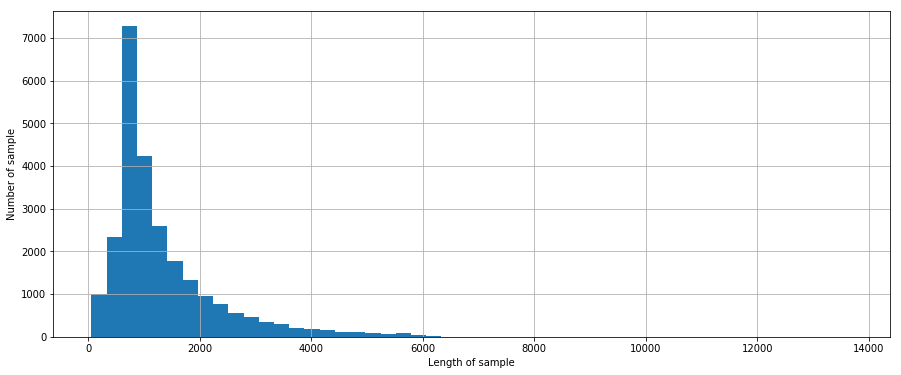

In [4]:
plt.figure(figsize=(15,6))
plt.hist([len(s) for s in X_train] , 50)
plt.xlabel("Length of sample")
plt.ylabel('Number of sample')
plt.grid()
plt.show()

**Visualizing the Frequency of each word**

In [5]:
kwargs ={ "ngram_range": (1,1)
        }
# instantiate the object 
count_vec = CountVectorizer(**kwargs)
vect_mat = count_vec.fit_transform(list(X_train))     # fit the method on the data
all_gram_names = count_vec.get_feature_names()        #Getting all the feature names
all_counts= vect_mat.sum(axis=0).tolist()[0]      # list of all the counts of n_gram

In [6]:
all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_gram_names), reverse=True)]) #unzipping 
ngrams = all_ngrams[:50]
counts = all_counts[:50]

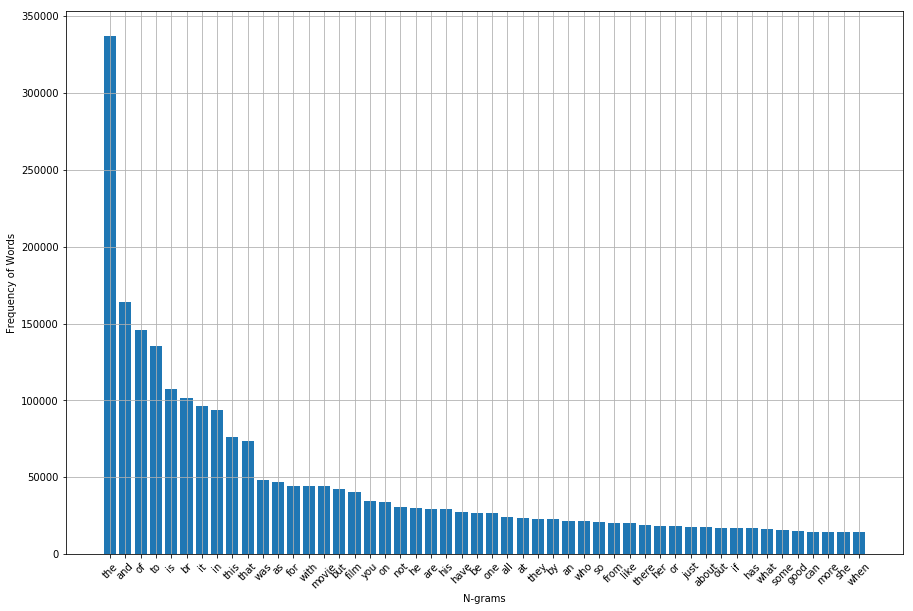

In [7]:

idx = np.arange(50)
plt.figure(figsize=(15,10))
plt.bar(idx , counts , width=0.8)
plt.xlabel("N-grams")
plt.ylabel("Frequency of Words")
plt.xticks(idx , ngrams , rotation=45)
plt.grid()
plt.show()

# 2.Helper functions

> Plotting T-SNE for different Vectors

In [8]:
def tsne_plot(x, y , c):
    kwargs ={
        "n_components": 3,
        'perplexity': 30,
        "learning_rate": 200
        }
    start = time.time()
    print("[INFO] starts...")
    tsne = TSNE(**kwargs)
    cat = ['avg' , 'weighted']
    if c not in cat:
        X_embeddings = tsne.fit_transform(x.toarray())
    else:    
        X_embeddings = tsne.fit_transform(np.array(x))
    data = np.hstack((X_embeddings , y.reshape(-1,1)))
    df = pd.DataFrame(data=data , columns=['Dim1' , 'Dim2','Dim3', 'Labels'])
    print("[INFO] ends....")
    color = { 0:"red" , 1:"blue"}
    fig =px.scatter_3d(df ,x='Dim1' , y='Dim2' ,z='Dim3', color='Labels')
    fig.show()
    print("Total time:", time.time()-start)

> Selecting the best 1000 features

In [9]:
def selector(x,y ,n):
    print("[INFO] the shape of matrix before selection:", x.shape)
    select= SelectKBest(f_classif , k=1000)
    select.fit(x, y)
    X= select.transform(x)
    print("[INFO] Reducing the number of rows due to memory issues")
    X = X[:n,:] 
    print("[INFO] the shape of matrix after selection:", X.shape)
    return X

> Text Prepocessing

In [10]:
def textprocess(sentence):
    
    sentence = sentence.lower()
    html = re.compile("<.*?>")
    sent = re.sub(html , " " , sentence)
    filtered_list=[]
    for s in sent.split():
        clean = re.sub(r'[?|/|\'|"|!|.|,|)|(|#]' , " " , s)
        for word in clean.split():
            if word.isalpha():
                filtered_list.append(word)
            else:
                continue
    
    return filtered_list
                

 > Average Word2vec

In [11]:
def avgW2V(sentence):
    
    sent_vec = np.zeros(50)
    count=0
    for word in sent:
        try:
            wordvec = W2V.wv[word]
            sent_vec += wordvec
            count+=1
        except:
            continue
    sent_vec= sent_vec/count        
    return sent_vec

In [12]:
def Weighted(sentence):
    
    sent_vec = np.zeros(50)
    weighted_sum=0
    for word in sent:
        try:
            wordvec = W2V.wv[word]
            tfidff = final_tfidf[row , features.index(word)]
            sent_vec += (wordvec*tfidff)
            weighted_sum+= tfidff
        except:
            continue
    sent_vec= sent_vec/weighted_sum
    return sent_vec

# 3. Bag of Words (BoW)

In [13]:
countVec = CountVectorizer(ngram_range=(1,2))
final_count = countVec.fit_transform(list(X_train))

In [14]:
final_count = selector(final_count, y_train , 1500)

[INFO] the shape of matrix before selection: (25000, 1513832)
[INFO] Reducing the number of rows due to memory issues
[INFO] the shape of matrix after selection: (1500, 1000)


In [15]:
tsne_plot(final_count , y_train[:1500] , 'bagofwords' )

[INFO] starts...
[INFO] ends....


Total time: 95.46734547615051


# 4. TF-IDF

In [16]:
tfidf = TfidfVectorizer(ngram_range=(1,2))
final_tfidf = tfidf.fit_transform(X_train)
features = tfidf.get_feature_names()

In [17]:
final_tfidf = selector(final_tfidf , y_train , 1500)

[INFO] the shape of matrix before selection: (25000, 1513832)
[INFO] Reducing the number of rows due to memory issues
[INFO] the shape of matrix after selection: (1500, 1000)


In [18]:
tsne_plot(final_tfidf , y_train[:1500] , 'tfidf')

[INFO] starts...
[INFO] ends....


Total time: 101.8061683177948


# 5. Word2Vec

In [19]:
list_of_sent=[]
for sent in t(X_train):
    filtered_list = textprocess(sent)
    list_of_sent.append(filtered_list)

100%|██████████| 25000/25000 [00:09<00:00, 2556.42it/s]


In [20]:
print(X_train[0])
print("\n", list_of_sent[0])

POSSIBLE SPOILERS<br /><br />The Spy Who Shagged Me is a muchly overrated and over-hyped sequel. International Man of Mystery came straight out of the blue. It was a lone star that few people had heard of. But it was stunningly original, had sophisticated humour and ample humour, always kept in good taste, and had a brilliant cast. The Spy Who Shagged Me was a lot more commercially advertised and hyped about.<br /><br />OK I'll admit, the first time I saw this film I thought it was very funny, but it's only after watching it two or three times that you see all the flaws. The acting was OK, but Heather Graham cannot act. Her performance didn't seem very convincing and she wasn't near as good as Liz Hurley was in the first one. Those characters who bloomed in the first one, (Scott Evil, Number 2 etc.) are thrown into the background hear and don't get many stand-alone scenes. The film is simply overrun with cameos.<br /><br />In particular, I hated the way they totally disregarded some of

In [21]:
W2V = Word2Vec(list_of_sent , min_count=5 , size=50 , workers=4)

> Checking similar words for given word.

In [22]:
W2V.wv.most_similar("fat")

[('blonde', 0.8002241253852844),
 ('blond', 0.7911092638969421),
 ('cat', 0.7613521218299866),
 ('suit', 0.7460131645202637),
 ('hot', 0.7409586906433105),
 ('wig', 0.7362731099128723),
 ('wearing', 0.7238660454750061),
 ('chick', 0.7142044305801392),
 ('dog', 0.7099012732505798),
 ('chicks', 0.705450177192688)]

In [23]:
W2V.wv.most_similar('man')

[('boy', 0.776054322719574),
 ('person', 0.7665964961051941),
 ('woman', 0.7663083076477051),
 ('doctor', 0.7415410280227661),
 ('guy', 0.7361608147621155),
 ('scientist', 0.7194809913635254),
 ('cop', 0.7175493240356445),
 ('soldier', 0.7084448933601379),
 ('girl', 0.6944401264190674),
 ('loser', 0.6639617681503296)]

# 6. Avg Word2Vec

In [24]:
sent_vectors =[]
for sent in t(list_of_sent):
    sent_vec= avgW2V(sent)
    sent_vectors.append(sent_vec)
#sent_vectors= np.array(sent_vectors)

100%|██████████| 25000/25000 [00:19<00:00, 1269.33it/s]


In [25]:
tsne_plot(sent_vectors[:1500] , y_train[:1500] , 'avg')

[INFO] starts...
[INFO] ends....


Total time: 115.54053616523743


# 7. TF-IDF weighted Word2vec

>  We will be using just 10 sentence to check the functioning of the code. TF-IDF + weighted Word2Vec takes a long time to excute whole dataset. Its advice to just to undestand the working code.

*  I am not plotting the T-sne plot because for 10 sentence it is returning NaN values which our helper function doesn't accept.

In [26]:
row = 0
weighted_vectors =[]

for sent in t(list_of_sent[:10]):
    sent_vec = Weighted(sent)
    weighted_vectors.append(sent_vec)
    row+=1

  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in true_divide

100%|██████████| 10/10 [03:13<00:00, 28.84s/it]
